# TP2 - Visión por computadora 1

Integrantes:
- Marco Joel Isidro (a1520)
- Diego Sarina (a1519)

Implementar un detector de máximo enfoque sobre un video aplicando técnicas de análisis espectral similar al que utilizan las cámaras digitales modernas. El video a procesar será: “focus_video.mov”.

## Parte 1

Se debe implementar un algoritmo que dada una imagen, o región, calcule la métrica propuesta en el paper "Image Sharpness Measure for Blurred Images in Frequency Domain“ y realizar tres experimentos:

1. Medición sobre todo el frame.
2. Medición sobre una ROI ubicada en el centro del frame.  Area de la ROI = 5 o 10% del area total del frame.
3. Medición sobre una matriz de enfoque compuesta por un arreglo de NxM elementos rectangulares equiespaciados. N y M son valores 
arbitrarios, probar con varios valores 3x3, 7x5, etc ... (al menos 3) 

Para cada experimento se debe presentar:
- Una curva o varias curvas que muestren la evolución de la métrica frame a frame donde se vea claramente cuando el algoritmo detecto el punto 
de máximo enfoque.
- Video con la ROI o matriz, graficada en rojo y superpuesta al video original para los frames que no están en foco y verde para los frames donde se detecta la condición de máximo enfoque

In [63]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from utils.utils import show_img, show_imgs, get_images_from_video, show_roi_on_image, show_imgs_with_roi
from utils.video import VideoPlayer
from IPython.display import display, Image
import ipywidgets as widgets
import threading
from typing import List
import numpy as np
from typing import Tuple
GridSize = Tuple[int, int]


A continuación vamos a definir la funcion `calculate_image_quality_measure` basado en el algoritmo que se visualiza en la imagen a continuación que pertenece al paper *Image Sharpness Measure for Blurred Images in Frequency Domain*

![Algoritmo Propuesto de FM](enunciado/proposed_algorithm.png)


In [64]:
# Declaración de la función `calculate_image_quality_measure` 
def calculate_image_quality_measure(image: np.ndarray) -> float:
    """
    Calcula la Medida de Calidad de Imagen (FM) basada en la Medida de Desenfoque en el Dominio de Frecuencia.
    Esta función calcula el valor FM para una imagen en escala de grises usando.

    args:
        image (np.ndarray): Input image in grayscale, represented as a 2D NumPy array.

    return:
        float: The Image Quality Measure (FM) of the input image.
        
    Example:
    >>> import cv2
    >>> import numpy as np
    >>> image = cv2.imread('path_to_image.jpg', cv2.IMREAD_GRAYSCALE)
    >>> fm = calculate_image_quality_measure(image)
    >>> print(f"Image Quality Measure (FM): {fm}")
    """

    # Step 1: Computar la transformada de Fourier de la imagen
    F = np.fft.fft2(image)

    # Step 2: Shift the zero-frequency component to the center of the spectrum
    Fc = np.fft.fftshift(F)

    # Step 3: Calcular el valor absoluto de la transformada de Fourier centrada
    AF = np.abs(Fc)

    # Step 4: Calcular el valor máximo de AF
    M = np.max(AF)

    # Step 5: Calcular T_H
    thres = M / 1000
    T_H = np.sum(AF > thres)

    # Step 6: Calcular la medida de calidad de imagen (FM)
    FM = T_H / (image.shape[0] * image.shape[1])

    return FM

In [65]:
# Declaro el path del video a leer
video_path = 'enunciado/focus_video.mov'

In [66]:
# Obtener imagenes del video para testeo
#get_images_from_video(video_path=video_path) # No necesito volver a correr esto


In [67]:
# Declaro referencias de imagenes con diferentes niveles de nitidez
imagen_borrosa = 'enunciado/frames/IMG_0000.jpg'
imagen_nitida = 'enunciado/frames/IMG_0092.jpg'
imagen_medio_borrosa = 'enunciado/frames/IMG_0060.jpg'
imagen_mas_nitida = 'enunciado/frames/IMG_0122.jpg'

imagenes_a_analizar = [imagen_borrosa, imagen_nitida, imagen_medio_borrosa, imagen_mas_nitida]

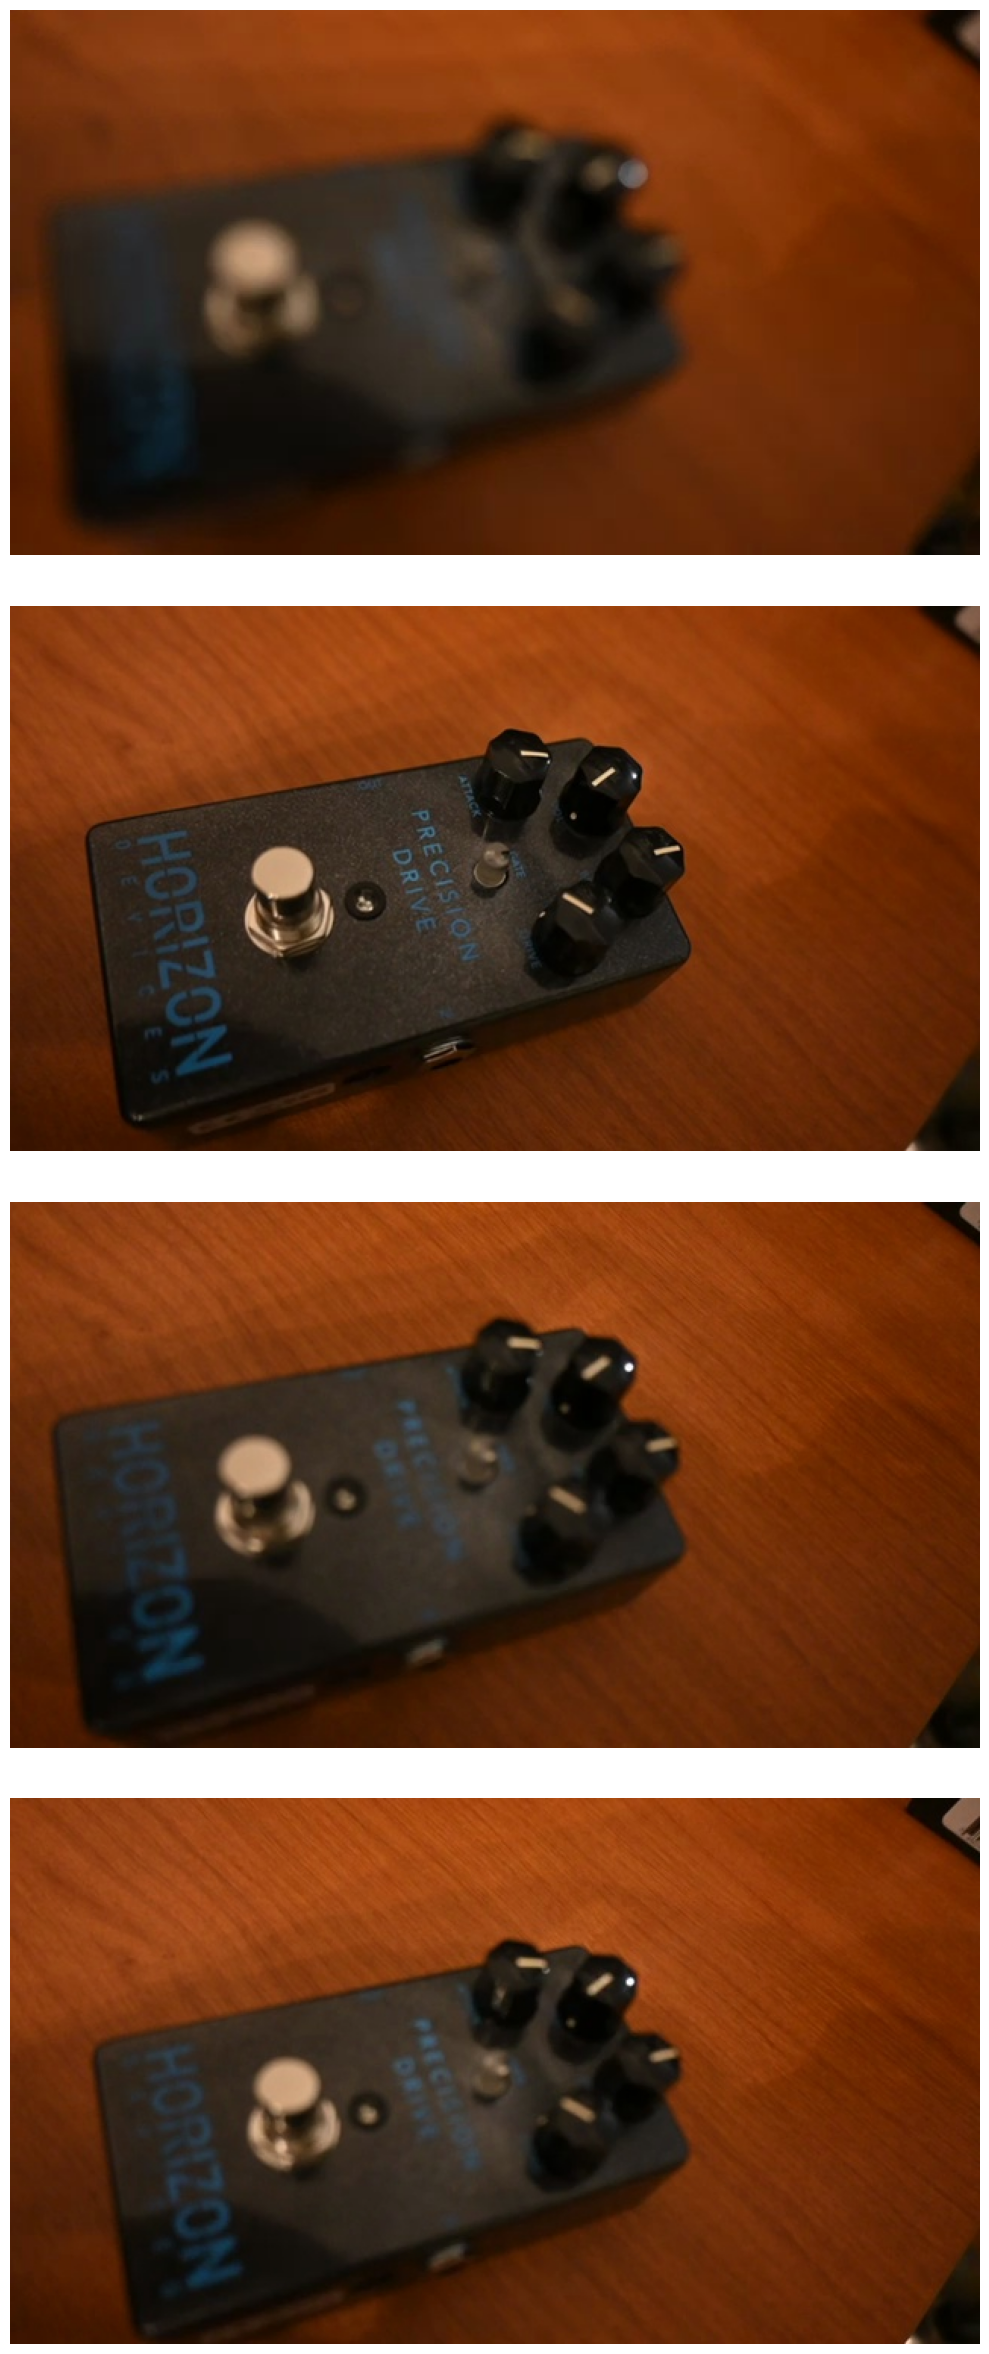

In [68]:
# Visulizo las imagenes

show_imgs(imagenes_a_analizar)

----

### Punto 1.1

- A continuación se visualiza la medición sobre todo el FRAME. Es decir que se analiza toda la imagen

In [69]:
# Calculo la metrica de enfoque para todo el frame, y para diferentes frames
image_quality_measure = [calculate_image_quality_measure(cv2.imread(i, cv2.IMREAD_GRAYSCALE)) for i in imagenes_a_analizar]

In [70]:
for i in image_quality_measure:
    print(f"Image Quality Measure (FM): {i}")

Image Quality Measure (FM): 0.0069487847222222225
Image Quality Measure (FM): 0.0266015625
Image Quality Measure (FM): 0.017951388888888888
Image Quality Measure (FM): 0.018511284722222222


NOTA: como podemos ver de la celda anterior, para el caso donde:

- FM = 0.0266015625 representa la imagen más nítida que analizamos que se corresponde a la imagen de muestra: `enunciado/frames/IMG_0092.jpg`
- FM = 0.0069487847222222225 representa la imagen más borrosa que analizamos que se corresponde a la imagen de muestra: `enunciado/frames/IMG_0000.jpg`

---

### Punto 1.2

- Medición sobre una ROI ubicada en el centro del frame.  Area de la ROI = 5 o 10% del area total del frame.

In [71]:
# Función para Medir ROI en el Centro del Frame

def calculate_roi_quality_measure(image: np.ndarray, roi_percentage:float=0.1)-> float:
    """
    Calcula la Medida de Calidad de Imagen (FM) para una región de interés (ROI) de la imagen.
    La ROI se define como un porcentaje del tamaño total de la imagen, centrada en el medio.

    args:
        image (np.ndarray): Input image in grayscale, represented as a 2D NumPy array.
        roi_percentage (float): The percentage of the image dimensions to define the ROI.
                                Default is 0.1 (10% of the image dimensions).

    return:
        float: The Image Quality Measure (FM) of the ROI of the input image.
    Example:
    >>> import cv2
    >>> import numpy as np
    >>> image = cv2.imread('path_to_image.jpg', cv2.IMREAD_GRAYSCALE)
    >>> fm_roi = calculate_roi_quality_measure(image, roi_percentage=0.1)
    >>> print(f"ROI Image Quality Measure (FM): {fm_roi}")
    """
    # Obtener las dimensiones de la imagen
    height, width = image.shape
    
    # Calcular las dimensiones de la ROI
    roi_height = int(height * roi_percentage)
    roi_width = int(width * roi_percentage)
    
    # Calcular las coordenadas de la ROI centrada
    y1 = height // 2 - roi_height // 2
    y2 = y1 + roi_height
    x1 = width // 2 - roi_width // 2
    x2 = x1 + roi_width
    
    # Extraer la ROI de la imagen
    roi = image[y1:y2, x1:x2]

    # Calcular la medida de calidad de imagen para la ROI
    return calculate_image_quality_measure(roi)


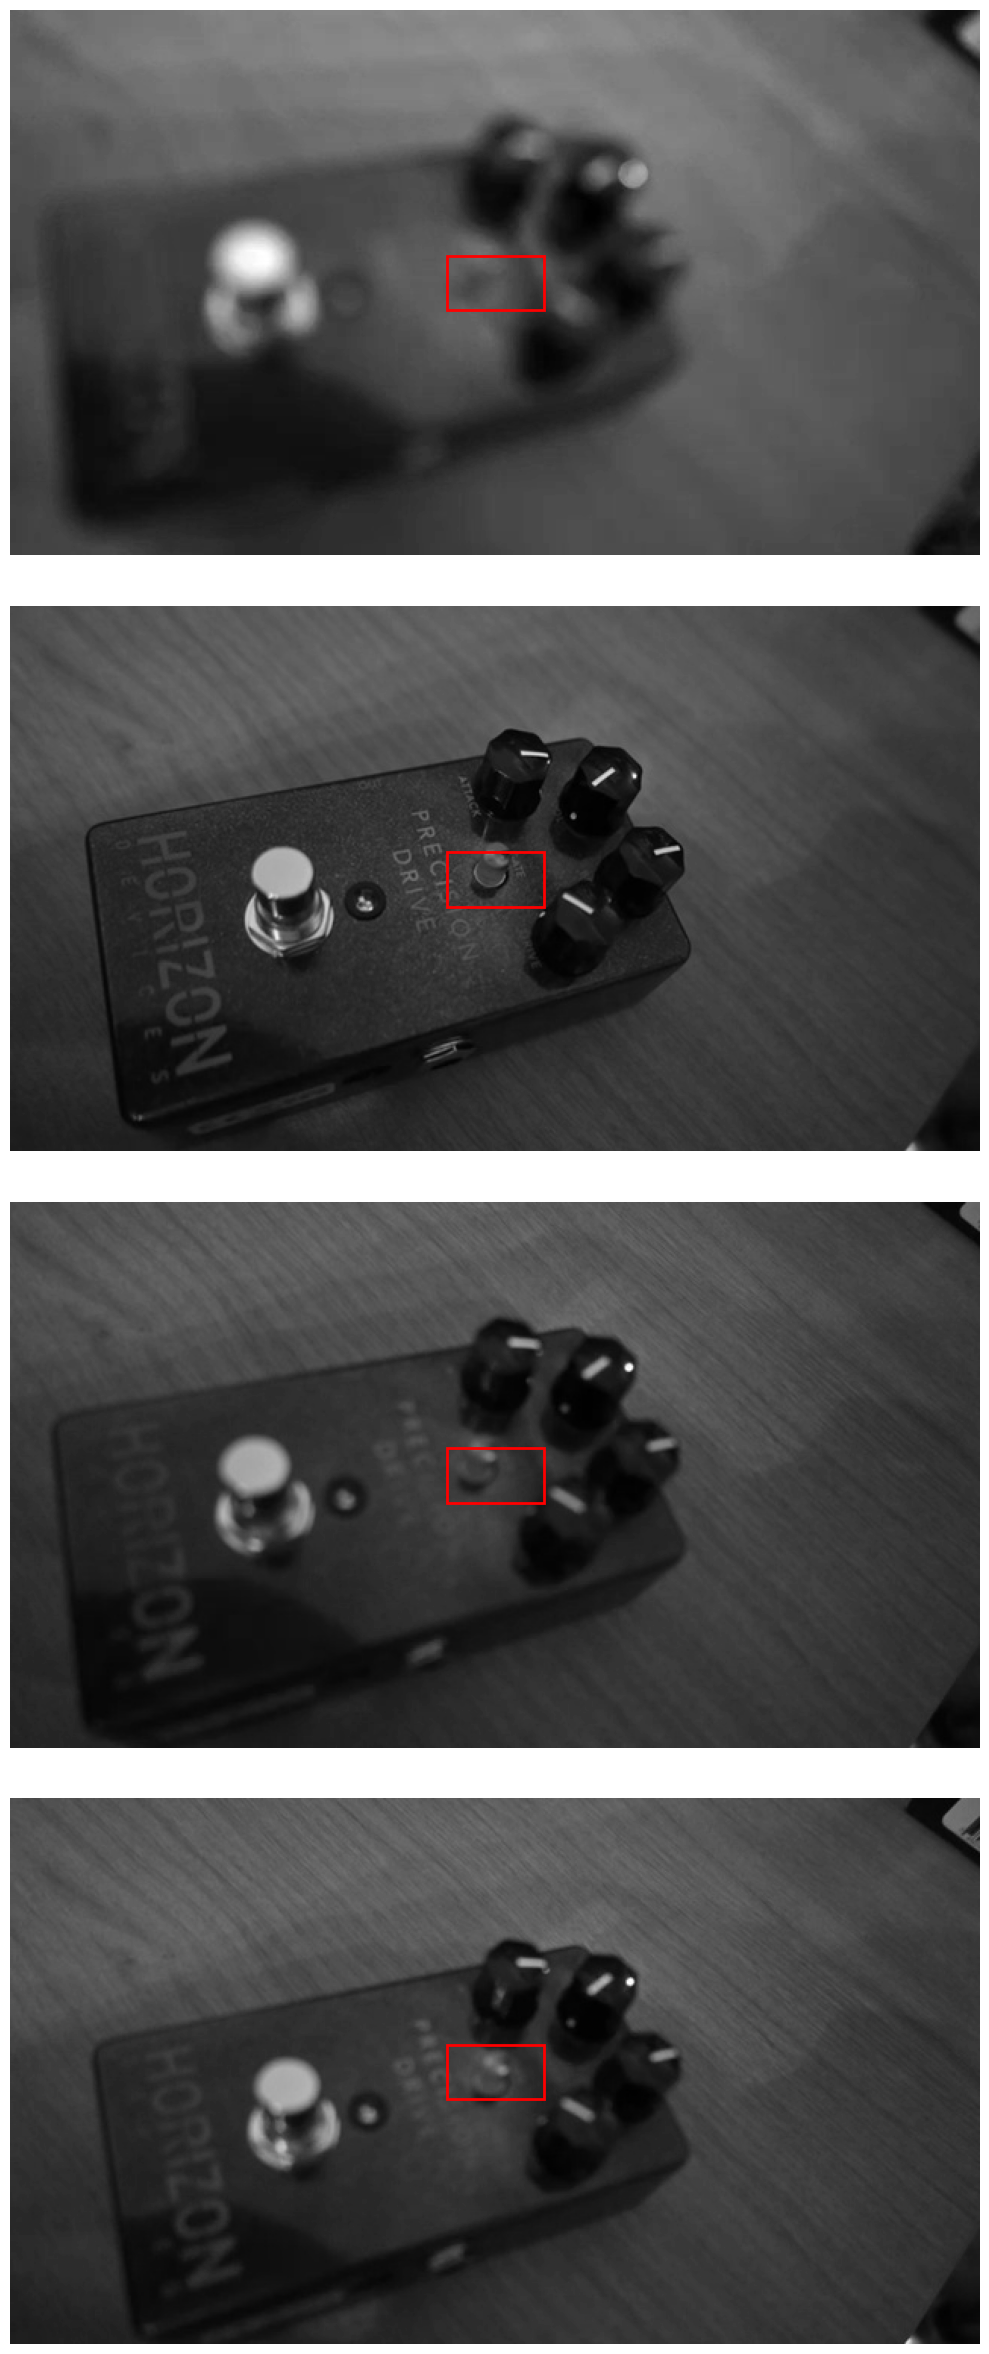

In [72]:
# Para las mismas imagenes, visulizo el roi de estas con un 10% (0.1)
show_imgs_with_roi(imagenes_a_analizar)

In [73]:
# Calculo la metrica de enfoque para las imagenes anteriores utilizando el mismo ROI que el visualizado (0.1)
image_quality_measure_ROI_01 = [calculate_roi_quality_measure(cv2.imread(i, cv2.IMREAD_GRAYSCALE)) for i in imagenes_a_analizar]

In [74]:
for i in image_quality_measure_ROI_01:
    print(f"Image Quality Measure (FM): {i}")

Image Quality Measure (FM): 0.14192708333333334
Image Quality Measure (FM): 0.6796875
Image Quality Measure (FM): 0.2287326388888889
Image Quality Measure (FM): 0.22352430555555555


NOTA: analogo al punto **1.1** vemos para el ROI del 10% en este caso y basados en las imágenes que:

- FM = 0.6796875 representa la imagen mas nitida que analizamos que se corresponde a la imagen de muestra: `enunciado/frames/IMG_0092.jpg`
- FM = 0.14192708333333334 representa la imagen mas borrosa que analizamos que se corresponde a la imagen de muestra: `enunciado/frames/IMG_0000.jpg`

----

### Punto 1.3

- Medición sobre una matriz de enfoque compuesta por un arreglo de NxM elementos rectangulares equiespaciados. N y M son valores arbitrarios, probar con varios valores 3x3, 7x5, etc ... (al menos 3) 

In [75]:
def calculate_focus_matrix_quality_measure(image: np.ndarray, grid_size: GridSize, scale_factor: float = 1.0) -> List[float]:
    """
    Calcula la Medida de Calidad de Enfoque (FM) en una matriz de sub-imágenes dentro de la imagen original.
    La imagen se divide en una grilla especificada por `grid_size` y se calcula la FM para cada sub-imagen.

    Args:
        image (np.ndarray): Imagen de entrada en escala de grises, representada como un array 2D de NumPy.
        grid_size (GridSize): Tamaño de la grilla para dividir la imagen (filas, columnas).
        scale_factor (float): Factor de escala para ajustar el tamaño de la grilla. Default es 1.0.

    Returns:
        List[float]: Lista de valores FM calculados para cada sub-imagen en la grilla.
        
    Example:
    >>> import cv2
    >>> import numpy as np
    >>> image = cv2.imread('path_to_image.jpg', cv2.IMREAD_GRAYSCALE)
    >>> grid_size = (4, 4)  # Dividir la imagen en una grilla de 4x4
    >>> fm_values = calculate_focus_matrix_quality_measure(image, grid_size, scale_factor=1.0)
    >>> print(f"Focus Matrix Quality Measures: {fm_values}")
    """

    height, width = image.shape
    rows, cols = grid_size
    
    # Calcular el tamaño ajustado de la grilla basado en el factor de escala
    scaled_height = int(height * scale_factor)
    scaled_width = int(width * scale_factor)
    
    step_y = scaled_height // rows
    step_x = scaled_width // cols
    
    fm_values = []
    
    center_y = height // 2
    center_x = width // 2
    
    start_y = center_y - (scaled_height // 2)
    start_x = center_x - (scaled_width // 2)
    
    for i in range(rows):
        for j in range(cols):
            y1 = start_y + i * step_y
            y2 = y1 + step_y
            x1 = start_x + j * step_x
            x2 = x1 + step_x
            
            sub_image = image[y1:y2, x1:x2]
            fm = calculate_image_quality_measure(sub_image)
            fm_values.append(fm)
    
    return fm_values

In [76]:
def plot_focus_matrix_on_image(image:np.ndarray, fm_matrix: List[float], grid_size: GridSize, scale_factor:float=1.0)-> None:
    """
    Plotea la matriz de enfoque en la imagen de entrada, dividiendo la imagen en una grilla de sub-imágenes basado
    en el parametro grid_size y el factor de escala scale_factor.

    Args:
        image (np.ndarray): Imagen de entrada, representada como un array 2D de NumPy.
        grid_size (GridSize): Tamaño de la grilla para dividir la imagen (filas, columnas).
        scale_factor (float): Factor de escala para ajustar el tamaño de la grilla. Default es 1.0.
    """
    height, width = image.shape
    
    # Calcular el tamaño ajustado de la grilla basado en el factor de escala
    scaled_height = int(height * scale_factor)
    scaled_width = int(width * scale_factor)
    
    rows, cols = grid_size
    step_y = scaled_height // rows
    step_x = scaled_width // cols
    
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.imshow(image, cmap='gray')

    center_y = height // 2
    center_x = width // 2
    
    start_y = center_y - (scaled_height // 2)
    start_x = center_x - (scaled_width // 2)

    # Añadir los valores de la matriz de enfoque como texto en cada subregión
    for i in range(rows):
        for j in range(cols):
            y1 = start_y + i * step_y
            y2 = y1 + step_y
            x1 = start_x + j * step_x
            x2 = x1 + step_x
            
            fm_value = fm_matrix[i * cols + j]
            
            # Dibujar el rectángulo
            rect = plt.Rectangle((x1, y1), step_x, step_y, edgecolor='green', facecolor='none', linewidth=1)
            ax.add_patch(rect)
            
            # Añadir el valor del FM en el centro del rectángulo
            ax.text(x1 + step_x / 2, y1 + step_y / 2, f'{fm_value:.2f}', color='yellow', ha='center', va='center', fontsize=6, bbox=dict(facecolor='black', alpha=0.5))

    ax.set_title(f'Matriz de enfoque con dimensiones {rows}x{cols} en imagen')
    plt.show()

In [77]:
images_in_grayscale = [cv2.imread(i, cv2.IMREAD_GRAYSCALE) for i in imagenes_a_analizar]

In [79]:
grid_size = (4, 4)  # Dividir la imagen en una grilla de 4x4

In [80]:
fm_matrix = calculate_focus_matrix_quality_measure(images_in_grayscale[1],grid_size, 0.7)

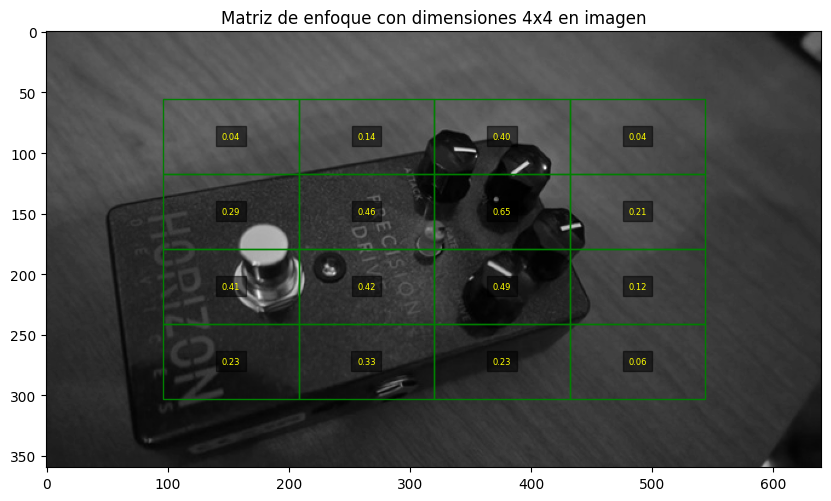

In [81]:
plot_focus_matrix_on_image(images_in_grayscale[1], fm_matrix, grid_size, 0.7)


In [95]:
# Calculo para matrices adicionales y para testear

grid_sizes = [(3, 3), (7,5), (4,4), (5,5)]
fm_stats = [calculate_focus_matrix_quality_measure(image=images_in_grayscale[1], grid_size=grid, scale_factor=0.7) for grid in grid_sizes]

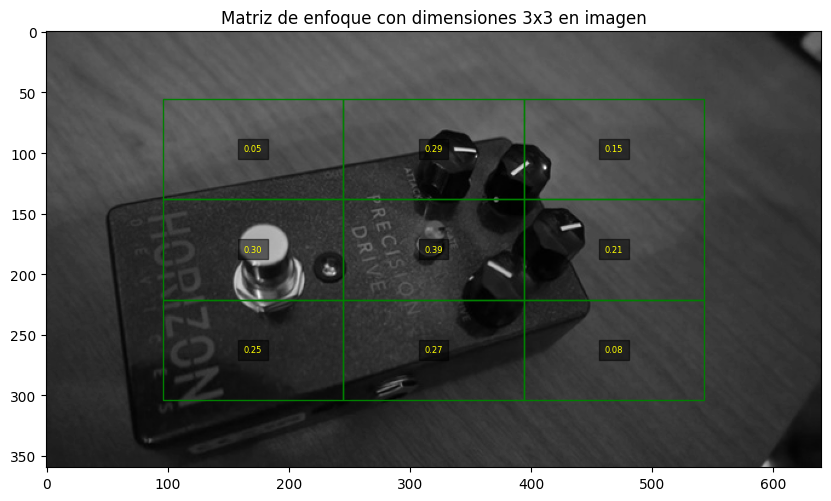

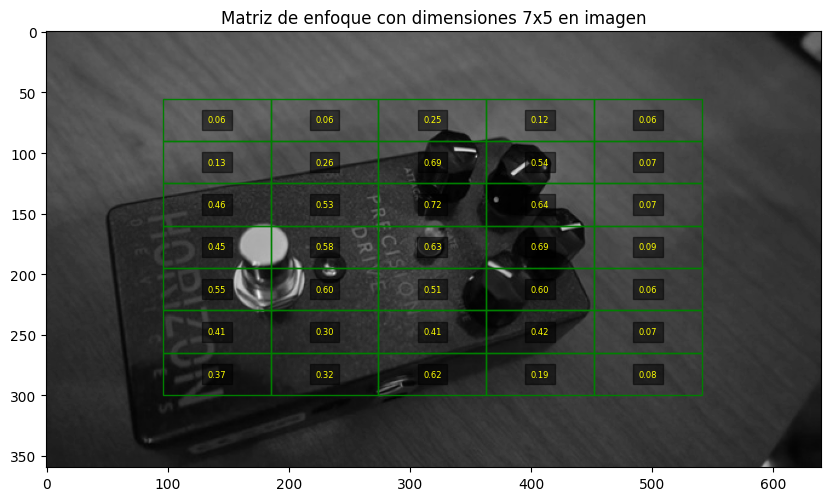

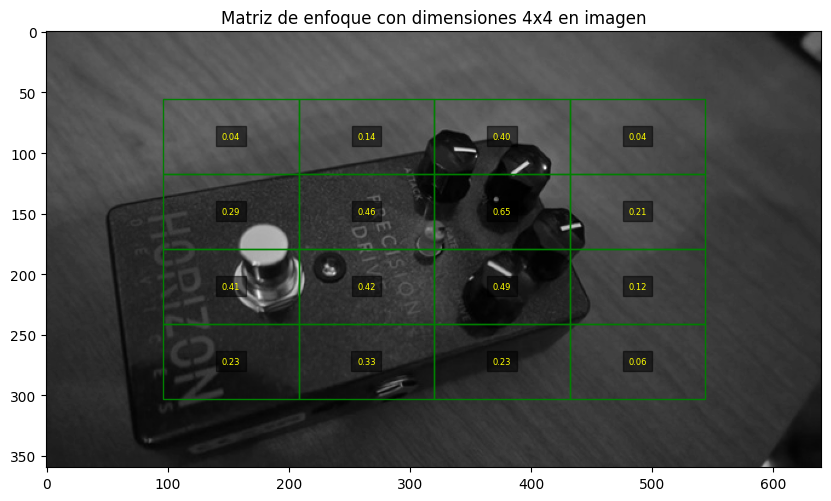

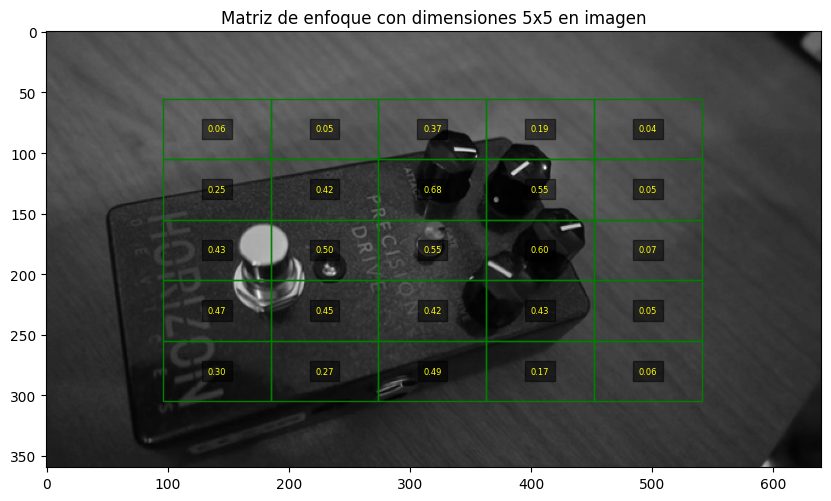

[None, None, None, None]

In [96]:
[plot_focus_matrix_on_image(image=images_in_grayscale[1], fm_matrix=fm_stats[i], grid_size=grid_sizes[i], scale_factor=0.7) for i in range(len(grid_sizes))]

#### TODO:
- aca calculamos la matriz de enfoque, y tenemos la segmentacion para solo una imagen
- me falta agregar la parte continua para todo un video
- ponderar los pesos (o no) sobre las regiones
- probar por lo menos con 3 matrices diferentes para ver los resultados

In [31]:
def process_video_for_quality(video_path: str):
    cap = cv2.VideoCapture(video_path)
    quality_measures = []
    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    
    for _ in range(frame_count):
        ret, frame = cap.read()
        if not ret:
            break
        gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        fm = calculate_image_quality_measure(gray_frame)
        quality_measures.append(fm)
    
    cap.release()
    return quality_measures

In [36]:
def plot_quality_measures(quality_measures: list):
    plt.plot(quality_measures)
    plt.xlabel('Frame')
    plt.ylabel('Quality Measure (FM)')
    plt.title('Evolucion FM en funcion del tiempo')
    plt.show()

In [32]:
video_path

'enunciado/focus_video.mov'

In [34]:
quality_measures = process_video_for_quality(video_path)


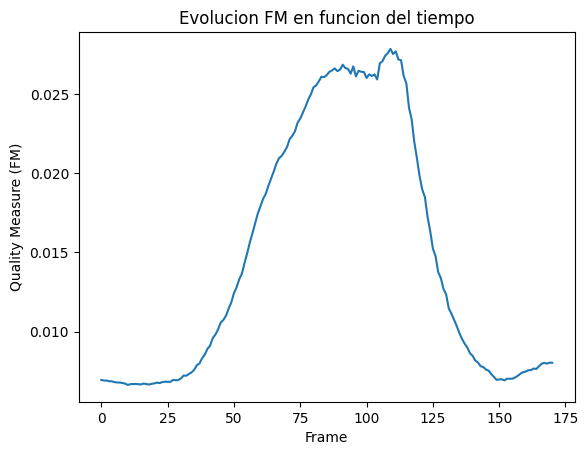

In [37]:
plot_quality_measures(quality_measures)


In [47]:
def process_video_for_qualityROI(video_path: str, roi_percentage: float = 0.1):
    cap = cv2.VideoCapture(video_path)
    quality_measures = []
    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    
    for _ in range(frame_count):
        ret, frame = cap.read()
        if not ret:
            break
        gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        fm = calculate_roi_quality_measure(gray_frame, roi_percentage)
        quality_measures.append(fm)
    
    cap.release()
    return quality_measures

In [51]:
quality_measures_ROI = process_video_for_qualityROI(video_path)


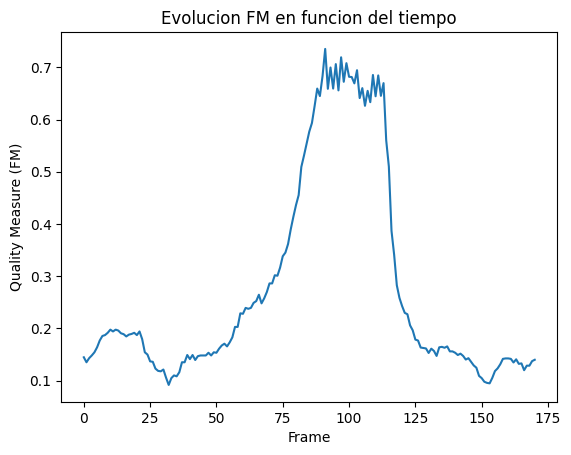

In [52]:
plot_quality_measures(quality_measures_ROI)


In [56]:
from typing import Tuple, List, Union

def process_video_for_quality(video_path: str, mode: str = 'full', roi_percentage: float = 0.1, grid_size: GridSize = (1, 1), scale_factor: float = 1.0) -> Union[List[float], List[List[float]]]:
    """
    Procesa un video para calcular las medidas de calidad de enfoque en diferentes modos.

    Args:
        video_path (str): Ruta del video de entrada.
        mode (str): Modo de cálculo de la calidad de enfoque ('full', 'roi', 'grid').
        roi_percentage (float): Porcentaje de la imagen para definir la ROI (solo para el modo 'roi').
        grid_size (GridSize): Tamaño de la grilla para dividir la imagen (solo para el modo 'grid').
        scale_factor (float): Factor de escala para ajustar el tamaño de la grilla (solo para el modo 'grid').

    Returns:
        Union[List[float], List[List[float]]]: Lista de medidas de calidad de enfoque.
    """
    cap = cv2.VideoCapture(video_path)
    quality_measures = []
    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    
    for _ in range(frame_count):
        ret, frame = cap.read()
        if not ret:
            break
        gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        
        if mode == 'full':
            fm = calculate_image_quality_measure(gray_frame)
            quality_measures.append(fm)
        elif mode == 'roi':
            fm = calculate_roi_quality_measure(gray_frame, roi_percentage)
            quality_measures.append(fm)
        elif mode == 'grid':
            fm_values = calculate_focus_matrix_quality_measure(gray_frame, grid_size, scale_factor)
            quality_measures.append(fm_values)
        else:
            raise ValueError("Invalid mode. Choose 'full', 'roi', or 'grid'.")
    
    cap.release()
    return quality_measures

In [57]:
quality_measures_grid = process_video_for_quality(video_path, mode='grid', grid_size=grid_size, scale_factor=0.7)


In [58]:
quality_measures_grid

[[np.float64(0.02390552995391705),
  np.float64(0.07877304147465437),
  np.float64(0.14588133640552994),
  np.float64(0.018577188940092165),
  np.float64(0.05040322580645161),
  np.float64(0.10469470046082949),
  np.float64(0.2530241935483871),
  np.float64(0.0429147465437788),
  np.float64(0.06638824884792627),
  np.float64(0.04507488479262673),
  np.float64(0.0907258064516129),
  np.float64(0.029953917050691243),
  np.float64(0.10469470046082949),
  np.float64(0.07819700460829493),
  np.float64(0.10527073732718895),
  np.float64(0.015697004608294932)],
 [np.float64(0.023617511520737326),
  np.float64(0.0790610599078341),
  np.float64(0.14501728110599077),
  np.float64(0.017713133640552995),
  np.float64(0.048099078341013825),
  np.float64(0.10527073732718895),
  np.float64(0.23487903225806453),
  np.float64(0.04089861751152074),
  np.float64(0.06451612903225806),
  np.float64(0.04161866359447004),
  np.float64(0.09115783410138249),
  np.float64(0.028225806451612902),
  np.float64(0.1

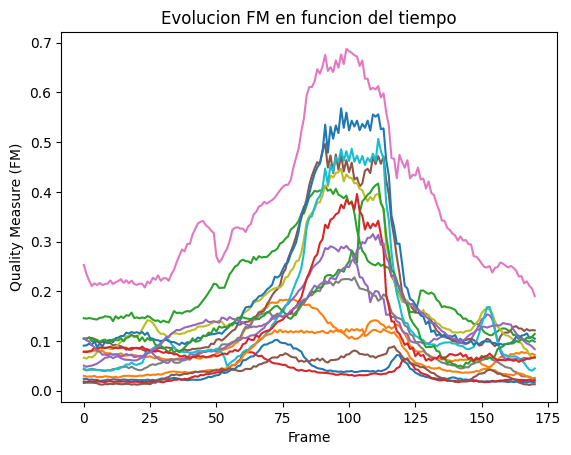

In [59]:
plot_quality_measures(quality_measures_grid) #TODO: CLARAMENTE NECESITAMOS OBTENER UN NUMERO DE ESTE PUNTO


In [53]:
def process_and_annotate_video(video_path: str, output_path: str, roi_percentage: float = 0.1):
    cap = cv2.VideoCapture(video_path)
    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = cap.get(cv2.CAP_PROP_FPS)
    
    out = cv2.VideoWriter(output_path, cv2.VideoWriter_fourcc(*'mp4v'), fps, (frame_width, frame_height))
    quality_measures = []
    
    # Calcular medidas de calidad
    for _ in range(frame_count):
        ret, frame = cap.read()
        if not ret:
            break
        gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        fm = calculate_roi_quality_measure(gray_frame, roi_percentage)
        quality_measures.append(fm)
    
    max_focus_frame = np.argmax(quality_measures)
    
    cap.set(cv2.CAP_PROP_POS_FRAMES, 0)  # Reset video to first frame
    
    # Procesar y anotar el video
    for i in range(frame_count):
        ret, frame = cap.read()
        if not ret:
            break
        height, width = frame.shape[:2]
        roi_height = int(height * roi_percentage)
        roi_width = int(width * roi_percentage)
        y1 = height // 2 - roi_height // 2
        y2 = y1 + roi_height
        x1 = width // 2 - roi_width // 2
        x2 = x1 + roi_width
        
        color = (0, 255, 0) if i == max_focus_frame else (0, 0, 255)
        cv2.rectangle(frame, (x1, y1), (x2, y2), color, 2)
        
        out.write(frame)
    
    cap.release()
    out.release()

# Usage
#video_path = 'path_to_video.mp4'
#output_path = 'output_video.mp4'
#process_and_annotate_video(video_path, output_path, roi_percentage=0.1)


In [54]:
process_and_annotate_video(video_path, 'enunciado/output.mov')

In [61]:
def process_and_annotate_video_with_thresh(video_path: str, output_path: str, roi_percentage: float = 0.1, threshold: float = None):
    cap = cv2.VideoCapture(video_path)
    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = cap.get(cv2.CAP_PROP_FPS)
    
    out = cv2.VideoWriter(output_path, cv2.VideoWriter_fourcc(*'mp4v'), fps, (frame_width, frame_height))
    quality_measures = []
    
    # Calcular medidas de calidad
    for _ in range(frame_count):
        ret, frame = cap.read()
        if not ret:
            break
        gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        fm = calculate_roi_quality_measure(gray_frame, roi_percentage)
        quality_measures.append(fm)
    
    if threshold is None:
        threshold = np.mean(quality_measures)
    
    cap.set(cv2.CAP_PROP_POS_FRAMES, 0)  # Reset video to first frame
    
    # Procesar y anotar el video
    for i in range(frame_count):
        ret, frame = cap.read()
        if not ret:
            break
        height, width = frame.shape[:2]
        roi_height = int(height * roi_percentage)
        roi_width = int(width * roi_percentage)
        y1 = height // 2 - roi_height // 2
        y2 = y1 + roi_height
        x1 = width // 2 - roi_width // 2
        x2 = x1 + roi_width
        
        color = (0, 255, 0) if quality_measures[i] >= threshold else (0, 0, 255)
        cv2.rectangle(frame, (x1, y1), (x2, y2), color, 2)
        
        out.write(frame)
    
    cap.release()
    out.release()

# Usage

In [62]:
process_and_annotate_video_with_thresh(video_path, 'enunciado/output_thresh.mov')

In [99]:
def process_and_annotate_video_with_thresh_multiple_mode(video_path: str, output_path: str, mode: str = 'roi', roi_percentage: float = 0.1, grid_size: GridSize = (1, 1), scale_factor: float = 1.0, threshold: float = None):
    cap = cv2.VideoCapture(video_path)
    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = cap.get(cv2.CAP_PROP_FPS)
    
    out = cv2.VideoWriter(output_path, cv2.VideoWriter_fourcc(*'mp4v'), fps, (frame_width, frame_height))
    quality_measures = []
    
    # Calcular medidas de calidad
    for _ in range(frame_count):
        ret, frame = cap.read()
        if not ret:
            break
        gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        
        if mode == 'roi':
            fm = calculate_roi_quality_measure(gray_frame, roi_percentage)
            quality_measures.append(fm)
        elif mode == 'grid':
            fm_values = calculate_focus_matrix_quality_measure(gray_frame, grid_size, scale_factor)
            fm_avg = np.mean(fm_values)
            quality_measures.append(fm_avg)
    
    if threshold is None:
        threshold = np.mean(quality_measures)
    
    cap.set(cv2.CAP_PROP_POS_FRAMES, 0)  # Reset video to first frame
    
    # Procesar y anotar el video
    for i in range(frame_count):
        ret, frame = cap.read()
        if not ret:
            break
        height, width = frame.shape[:2]
        
        if mode == 'roi':
            roi_height = int(height * roi_percentage)
            roi_width = int(width * roi_percentage)
            y1 = height // 2 - roi_height // 2
            y2 = y1 + roi_height
            x1 = width // 2 - roi_width // 2
            x2 = x1 + roi_width
            
            color = (0, 255, 0) if quality_measures[i] >= threshold else (0, 0, 255)
            cv2.rectangle(frame, (x1, y1), (x2, y2), color, 2)
        
        elif mode == 'grid':
            rows, cols = grid_size
            step_y = height // rows
            step_x = width // cols
            is_in_focus = all(fm >= threshold for fm in calculate_focus_matrix_quality_measure(cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY), grid_size, scale_factor))
            color = (0, 255, 0) if is_in_focus else (0, 0, 255)
            
            for i in range(rows):
                for j in range(cols):
                    y1 = i * step_y
                    y2 = y1 + step_y
                    x1 = j * step_x
                    x2 = x1 + step_x
                    cv2.rectangle(frame, (x1, y1), (x2, y2), color, 2)
        
        out.write(frame)
    
    cap.release()
    out.release()

In [101]:
process_and_annotate_video_with_thresh_multiple_mode(video_path, 'enunciado/output_thresh_nuevo.mov', mode='roi', grid_size=(4, 4), scale_factor=0.7)


## Parte 2

Cambiar la métrica de enfoque eligiendo uno de los algoritmos explicados en el apéndice de: Analysis of focus measure operators in shapefrom focus. El algoritmo de detección a implementar debe detectar y devolver los puntos de máximo enfoque de manera automática.

In [2]:
video_path = 'enunciado/focus_video.mov'

In [3]:
player = VideoPlayer(video_path=video_path)


In [ ]:
def modified_laplacian_focus_measure(image: np.ndarray) -> np.float64:
    """Implementación de la medida de enfoque de Laplaciano modificado LAP2
    de Nayar.

    Parameters
    ----------
    image : numpy array
        Imagen de entrada.
    
    Returns
    -------
    focus_measure : np.float64
        medida de enfoque calculada.
    """
    # Definir las máscaras de convolución
    Lx = np.array([[-1, 2, -1]])
    Ly = Lx.T

    # Aplicar las convoluciones
    Ix = cv2.filter2D(image, -1, Lx)
    Iy = cv2.filter2D(image, -1, Ly)

    # Calcular el Laplaciano modificado
    laplacian_modified = np.abs(Ix) + np.abs(Iy)

    # Calcular la medida de enfoque
    focus_measure = np.mean(laplacian_modified)

    return focus_measure

# Leer la imagen en escala de grises
image = cv2.imread('enunciado\\frames\\IMG_0157.jpg', cv2.IMREAD_GRAYSCALE)

# Calcular la medida de enfoque
focus_measure = modified_laplacian_focus_measure(image)

print(f'Focus Measure: {focus_measure}')

In [5]:
# cap = cv2.VideoCapture(video_path)
# cap.set(3,640) # adjust width
# cap.set(4,480) # adjust height

# while True:
#     success, img = cap.read()

#     if not success:
#         print("Failed to read frame")
#         continue  # Exit loop if frame not read properly

#     cv2.imshow("Webcam", img) # This will open an independent window
    
#     if cv2.waitKey(1) & 0xFF==ord('q'): # quit when 'q' is pressed
#         break

# cap.release()
# cv2.destroyAllWindows() 
# cv2.waitKey(1) # normally unnecessary, but it fixes a bug on MacOS where the window doesn't close

In [6]:
import cv2
import ipywidgets as widgets
from IPython.display import display, clear_output
from threading import Thread

class VideoPlayer:
    def __init__(self, video_path):
        self.video_path = video_path
        self.cap = cv2.VideoCapture(video_path)
        self.frame_count = int(self.cap.get(cv2.CAP_PROP_FRAME_COUNT))
        self.frame_rate = self.cap.get(cv2.CAP_PROP_FPS)
        self.current_frame = 0
        self.playing = False
        self.show_info = False

        # Controles
        self.play_pause_button = widgets.Button(description="Play")
        self.next_button = widgets.Button(description="Next Frame")
        self.info_checkbox = widgets.Checkbox(value=False, description='Show Info')
        self.controls = widgets.HBox([self.play_pause_button, self.next_button, self.info_checkbox])

        # Conectar eventos
        self.play_pause_button.on_click(self.toggle_play_pause)
        self.next_button.on_click(self.next_frame)
        self.info_checkbox.observe(self.toggle_info, names='value')

    def display_controls(self):
        display(self.controls)
        self.show_frame()

    def toggle_play_pause(self, b):
        if self.playing:
            self.playing = False
            self.play_pause_button.description = "Play"
        else:
            self.playing = True
            self.play_pause_button.description = "Pause"
            Thread(target=self.play).start()

    def next_frame(self, b):
        self.playing = False
        self.play_pause_button.description = "Play"
        self.current_frame += 1
        if self.current_frame >= self.frame_count:
            self.current_frame = 0
        self.cap.set(cv2.CAP_PROP_POS_FRAMES, self.current_frame)
        self.show_frame()

    def toggle_info(self, change):
        self.show_info = change['new']
        self.show_frame()

    def play(self):
        while self.playing:
            ret, frame = self.cap.read()
            if not ret:
                self.playing = False
                self.play_pause_button.description = "Play"
                break

            self.current_frame += 1
            if self.show_info:
                cv2.putText(frame, f'Frame: {self.current_frame}/{self.frame_count}', (10, 30),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), 2)
                elapsed_time = self.current_frame / self.frame_rate
                cv2.putText(frame, f'Time: {elapsed_time:.2f}s', (10, 60),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), 2)

            _, buffer = cv2.imencode('.jpg', frame)
            display_img = widgets.Image(value=buffer.tobytes(), format='jpg', width=640, height=480)
            clear_output(wait=True)
            display(self.controls)
            display(display_img)

            if cv2.waitKey(int(1000 / self.frame_rate)) & 0xFF == ord('q'):
                break

    def show_frame(self):
        self.cap.set(cv2.CAP_PROP_POS_FRAMES, self.current_frame)
        ret, frame = self.cap.read()
        if ret:
            if self.show_info:
                cv2.putText(frame, f'Frame: {self.current_frame}/{self.frame_count}', (10, 30),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), 2)
                elapsed_time = self.current_frame / self.frame_rate
                cv2.putText(frame, f'Time: {elapsed_time:.2f}s', (10, 60),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), 2)

            _, buffer = cv2.imencode('.jpg', frame)
            display_img = widgets.Image(value=buffer.tobytes(), format='jpg', width=640, height=480)
            clear_output(wait=True)
            display(self.controls)
            display(display_img)

In [ ]:
player = VideoPlayer(video_path)
player.display_controls()

Image(value=b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00\x01\x00\x00\xff\xdb\x00C\x00\x02\x01\x0…

# Parte extra

Aplicar unsharp masking para expandir la zona de enfoque y devolver.

In [ ]:
def unsharp_masking(image, kernel_size=(5, 5), sigma=1.0, amount=1):
    # Desenfocar la imagen
    blurred = cv2.GaussianBlur(image, kernel_size, sigma)
    
    # Calcular la máscara
    mask = image - blurred
    
    # Aplicar la máscara a la imagen original
    sharpened = np.clip(image + amount * mask, 0, 255).astype(np.uint8)

    return sharpened

# aplicar unsharp masking a un video
# Leer el video
video = cv2.VideoCapture('enunciado\\focus_video.mov')

# Crear el video de salida
fourcc = cv2.VideoWriter_fourcc(*'XVID')
out = cv2.VideoWriter('enunciado\\video_unsharp.avi', fourcc, 30.0, (640, 360))

k = 1

while video.isOpened():
    ret, frame = video.read()
    if ret == True:
        # float32
        frame = frame.astype(np.float32)

        unsharp = unsharp_masking(frame,amount=5)

        # Mostrar el frame
        cv2.imshow('Frame', frame.astype(np.uint8))
        cv2.imshow('unsharp', unsharp)

        # Guardar el frame en el video de salida
        out.write(unsharp)

        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
    else:
        break

video.release()
out.release()
cv2.destroyAllWindows()